# Lab 1 - Question 1 : High-frequency data and limit order books (DHF)

### Librairies

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import statsmodels.api as sm
import powerlaw
import scipy.stats as stats

## Part I

### 1. Dataset. Perform general statistical analyses on the datasets. Are the results expected ? Perform some sanity checks on the data. Is the dataset free of visible problems ?

In [2]:
def get_all_files(directory):
    files = [f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f))]
    return files

files = get_all_files(os.path.join('data', 'SG'))

dfs = []

for i, file in enumerate(files):
    df_small = pd.read_csv(os.path.join('data', 'SG', file), index_col = 0)
    dfs.append(df_small)
    #if i == 1:
        #break  # < ----------------- remove this line to read all files
df = pd.concat(dfs)
df['ets'] = pd.to_datetime(df['ets'], format='%Y%m%d:%H:%M:%S.%f')
df = df.sort_values(by='ets')
df.head()

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445


In [3]:
df.tail()

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
701263,2017-02-01 17:29:59.286593,M,46005,0,B,46005,552,46030,640
701264,2017-02-01 17:29:59.287101,C,46030,230,S,46005,552,46030,410
701265,2017-02-01 17:29:59.529079,A,46055,167,S,46005,552,46030,410
701266,2017-02-01 17:29:59.543106,M,45085,0,B,46005,412,46030,410
701267,2017-02-01 17:29:59.596217,M,46005,0,B,46005,552,46030,410


### Sanity Checks : General Statistics, Best Bid < Best Ask, Quantities Positive and Reasonable Price Levels :

In [4]:
print(df.isna().sum())
print("---------------------------------------------------------------")
df.info()
print("---------------------------------------------------------------")
print(df.describe())
print("---------------------------------------------------------------")
print("Event type counts:\n", df['etype'].value_counts())

ets       0
etype     0
eprice    0
eqty      0
eside     0
bp0       0
bq0       0
ap0       0
aq0       0
dtype: int64
---------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 7827010 entries, 0 to 701267
Data columns (total 9 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ets     datetime64[ns]
 1   etype   object        
 2   eprice  int64         
 3   eqty    int64         
 4   eside   object        
 5   bp0     int64         
 6   bq0     int64         
 7   ap0     int64         
 8   aq0     int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 597.2+ MB
---------------------------------------------------------------
                                 ets        eprice          eqty  \
count                        7827010  7.827010e+06  7.827010e+06   
mean   2017-01-24 22:36:25.109865984  4.630138e+04  2.330215e+02   
min       2017-01-17 09:01:00.270164  4.600000e+03 -2.217800e+

In [5]:
group_stats = df.groupby('etype').agg({
    'eprice': ['mean', 'min', 'max'],
    'eqty': ['mean', 'min', 'max', 'count']
})
print(group_stats)

             eprice                       eqty                       
               mean    min     max        mean    min    max    count
etype                                                                
A      46301.927156   4600  180000  261.443195      1  50000  3582649
C      46296.916765   4600  180000  255.844815      1  34022  3421149
M      46295.192661  24480   58230  -29.744663 -22178  17163   635651
T      46393.129195  44620   48860  164.354930      1  13860   187561


In [6]:
# Check how often bid is not strictly below ask
invalid_quotes = df[df['bp0'] > df['ap0']]
if len(invalid_quotes) > 0:
    print("Crossed market found:\n", invalid_quotes)
else:
    print("No crossed markets detected.")

if (df['eqty'] < 0).any():
    print("WARNING: Negative eqty found.")
else:
    print("No neg eqty found.")

    
if (df['bq0'] < 0).any() or (df['aq0'] < 0).any():
    print("WARNING: Negative best quote sizes found.")
else:
    print("no negative best quote sizes found")


if (df['eprice'] <= 0).any():
    print("WARNING: Non-positive eprice found.")
else:
    print("No neg eprice")


No crossed markets detected.
no negative best quote sizes found
No neg eprice


In [7]:
# negative eqty filtering
df_negative_eqty = df[df['eqty'] < 0]
print(f"Number of negative eqty rows: {len(df_negative_eqty)}")
print(df_negative_eqty.head())

Number of negative eqty rows: 111329
                           ets etype  eprice  eqty eside    bp0   bq0    ap0  \
173 2017-01-17 09:01:09.766010     M   46195  -200     S  46040   660  46100   
245 2017-01-17 09:01:13.855505     M   46190  -200     S  46050   735  46100   
335 2017-01-17 09:01:16.658868     M   46050  -200     B  46100   530  46165   
358 2017-01-17 09:01:18.518978     M   46030  -200     B  46100   891  46165   
383 2017-01-17 09:01:22.111607     M   46240  -200     S  46100  1302  46165   

     aq0  
173   19  
245   19  
335  397  
358  397  
383  397  


### Explanation :

After some research : Some feeds or data vendors represent a modification as “reduce the existing order size by X” and will report this X as negative.
For instance, if an order had a size of 300 shares and you see an “M” event with eqty = -50, that means the new order size is 250 shares so there are no errors or modifications, we just need to consider it that way.

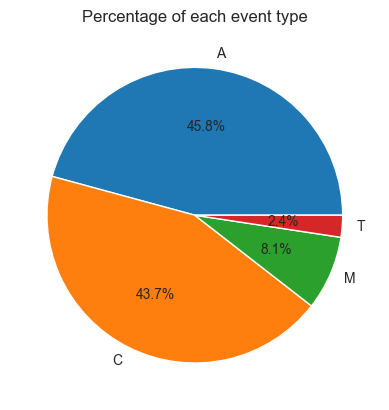

In [30]:
plt.title("Percentage of each event type")
plt.pie(df['etype'].value_counts() / 
        len(df), labels=df['etype'].value_counts().index, autopct='%1.1f%%')
plt.show()

There are 4 types of orders in the dataset :

- A: add limit order
- T: Trade (takes the best price)
- M: Modification
- C: Cancel

Only 2.1% of real match-making trades really taking place out of all of the placed orders !

### 2. Prices and tick sizes. Plot the best bid price, best ask price, mid price and weighted mid-price on a few minutes of your sample. Comment. Measure the tick sizes on your datasets. Are the measured values of the tick sizes in agreement with the official definition ?

#### 2.1 Best Bid/Ask Price

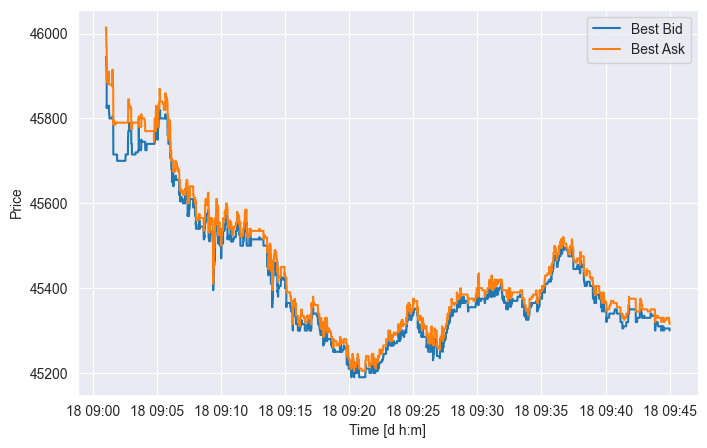

In [29]:

df_2 = df.copy()
df_2.set_index('ets', inplace=True)
df_2.sort_index(inplace=True, ascending=True)

start_date = '2017-01-18 09:01:00.270164'
end_date = '2017-01-18 09:45:00.00'

df_subset = df_2.loc[start_date:end_date]

sns.set_style("darkgrid")

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_subset, x=df_subset.index, y='bp0', label="Best Bid")
sns.lineplot(data=df_subset, x=df_subset.index, y='ap0', label="Best Ask")

plt.ylabel('Price')
plt.xlabel('Time [d h:m]')
plt.legend()
plt.show()


#### 2.2 A Closer Look with mid price and weighted mid-price added

The **mid-price** is defined as :

$$Mid\text{-}Price = \frac{a(t) + b(t)}{2}$$

The **weighted mid-price** is defined as:

$$W_{mid-price} = \frac{a(t)q^B(t) + b(t)q^A(t)}{q^B(t) + q^A(t)}$$

In [ ]:
# bp0, bq0,	ap0, aq0
# best bid price, best bid quantity, best ask price, best ask quantity

df['mid_price'] = (df['bp0'] + df['ap0']) / 2
df['weighted_mid_price'] = ((df['bp0'] * df['aq0']) \
    + (df['ap0'] * df['bq0'])) / (df['bq0'] + df['aq0'])

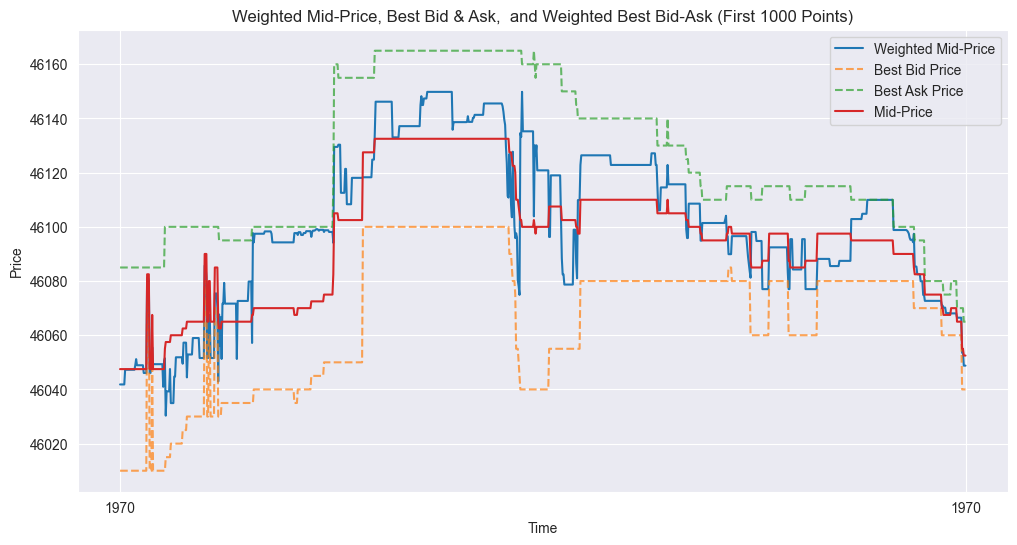

In [ ]:
df_subset = df.iloc[:1000]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_subset, x=df_subset.index, 
    y="weighted_mid_price", label="Weighted Mid-Price", linewidth=1.5)
sns.lineplot(data=df_subset, x=df_subset.index, 
    y="bp0", label="Best Bid Price", linestyle="--", alpha=0.7)
sns.lineplot(data=df_subset, x=df_subset.index, 
    y="ap0", label="Best Ask Price", linestyle="--", alpha=0.7)
sns.lineplot(data=df_subset, x=df_subset.index, 
    y="mid_price", label="Mid-Price", linewidth=1.5)

plt.xlabel("Time")
plt.ylabel("Price")
plt.title(
    "Weighted Mid-Price, Best Bid & Ask, " + \
        " and Weighted Best Bid-Ask (First 1000 Points)"
    )
plt.legend()
plt.show()

The graph doesnt show any issue about the calculation of the mid price and the weighted mid price. We can appreciate that the price of the stock is discrete along the time, where there are some specific moments where the bid and ask prices converges to the same value.

### 2.3 Tick size

In [43]:
df_trades_abnormal = df[(df["eprice"] > 50000)  & (df['etype'] == 'T')]
df_trades_abnormal.head()

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,mid_price,weighted_mid_price,tick_size_bid,tick_size_ask,spread,ts_next,delta


No trades above the price of 50 euros. 

In [39]:
df['tick_size_bid'] = df['bp0'].diff().abs()
df['tick_size_ask'] = df['ap0'].diff().abs()

tick_sizes = pd.concat(
  [df['tick_size_bid'], df['tick_size_ask']]
  ).replace(0, np.nan).dropna()

measured_tick_size = tick_sizes.min()

print(f'The smallest tick size occuring on the dataset is in line',
  f'with the official tick size : {measured_tick_size}',
  f'for stocks between 9.99 and 50 Euros as outlined in the course.',
  sep="\n")

The smallest tick size occuring on the dataset is in line
with the official tick size : 5.0
for stocks between 9.99 and 50 Euros as outlined in the course.


### 3. Trades. Are the empirical distributions of the trade durations and trade sizes on your datasets in agreement with known stylized facts ?

A power-law distribution follows the form:

\begin{equation}
    P(x) \propto x^{-\alpha}
\end{equation}

where:

- $\alpha$ is the scaling exponent, determining how quickly the probability decays.
- The $x_{min}$ is the lower bound, meaning the power-law behavior holds only for values greater than or equal to this threshold.

The alpha of the data is higher than 2 but lower than 3, which means that the data has a finite mean, but an infinite variance, which also means that the data has heavier tails than an exponential distribution.

#### 3.1 Trade Durations

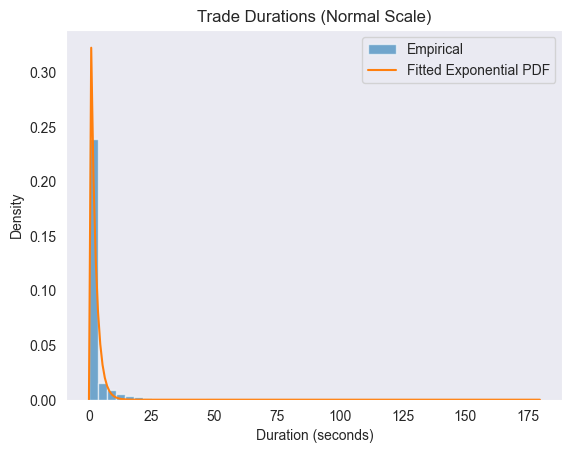

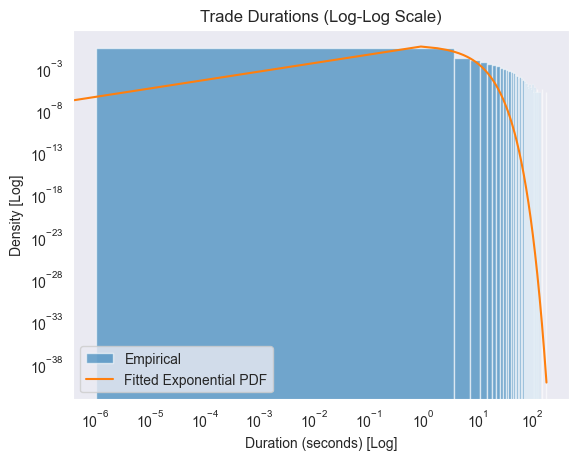

In [44]:
df_trades = df[df['etype'] == 'T'].copy()
df_trades['ets'] = pd.to_datetime(df_trades['ets'])
df_trades = df_trades.set_index('ets').sort_index()

# Restrict to trading hours (09:00:00–17:30:00)
df_trades = df_trades.between_time('09:00:00', '17:30:00')

# Compute durations within each day and 
# group by date so that .diff() doesn't span overnight
def add_daily_durations(group):
    group = group.sort_index()
    group['trade_duration'] = group.index.to_series().diff().dt.total_seconds()
    return group

# Group by each calendar day
df_trades = df_trades.groupby(df_trades.index.date, group_keys=False
                              ).apply(add_daily_durations)


df_trades = df_trades.dropna(subset=['trade_duration']) # first trade of each day

loc, scale = stats.expon.fit(df_trades['trade_duration'])
x_fit = np.linspace(0, df_trades['trade_duration'].max(), 200)
y_fit = stats.expon.pdf(x_fit, loc=loc, scale=scale)

plt.figure()
plt.hist(df_trades['trade_duration'], 
         bins=50, density=True, alpha=0.6, label='Empirical')
plt.plot(x_fit, y_fit, label='Fitted Exponential PDF')
plt.title("Trade Durations (Normal Scale)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.hist(df_trades['trade_duration'], 
         bins=50, density=True, alpha=0.6, label='Empirical')
plt.plot(x_fit, y_fit, label='Fitted Exponential PDF')
plt.xscale("log")
plt.yscale("log")
plt.title("Trade Durations (Log-Log Scale)")
plt.xlabel("Duration (seconds) [Log]")
plt.ylabel("Density [Log]")
plt.legend()
plt.grid()
plt.show()

We can appreciate in the previous graph, that the data doesnt follow a exponential distribution. We can see that the data has heavier tails than this distribution. This is in concordance with the course content.

#### Trades Volumes

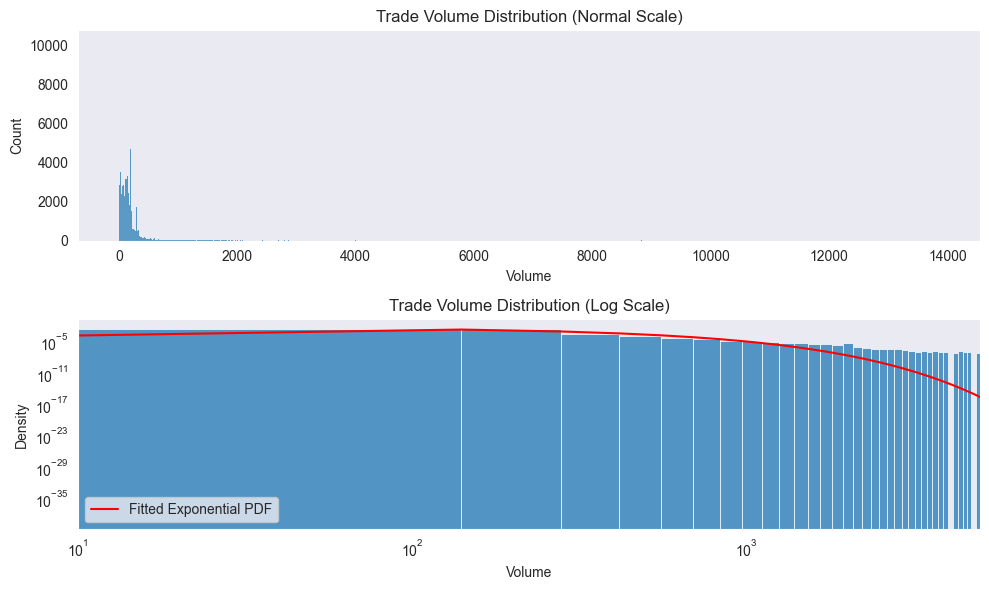

In [14]:
df_trades = df[df['etype'] == 'T'].copy()

loc, scale = stats.expon.fit(df_trades['eqty'])

x_fit = np.linspace(0, np.max(df_trades['eqty']), 100)
y_fit = stats.expon.pdf(x_fit, loc=loc, scale=scale)


fig, axes = plt.subplots(2, 1, figsize=(10, 6))

sns.histplot(df_trades, x='eqty', kde=False, ax=axes[0])
axes[0].set_title('Trade Volume Distribution (Normal Scale)')
axes[0].set_xlabel('Volume')
axes[0].grid()

sns.histplot(df_trades, x='eqty', 
             kde=False, stat='density', bins=100, ax=axes[1])
sns.lineplot(x=x_fit, y=y_fit, 
             color='red', ax=axes[1], label='Fitted Exponential PDF')
axes[1].set_xlim(1e1, 5e3)
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Volume')
axes[1].set_ylabel('Density')
axes[1].set_title('Trade Volume Distribution (Log Scale)')
axes[1].grid()

plt.tight_layout()
plt.show()

From the graph above, we can appreciate that the trade volumes doesnt follow a exponential distribution. We can see that is has heavier tails than this distribution. This is in concordance with the course content.

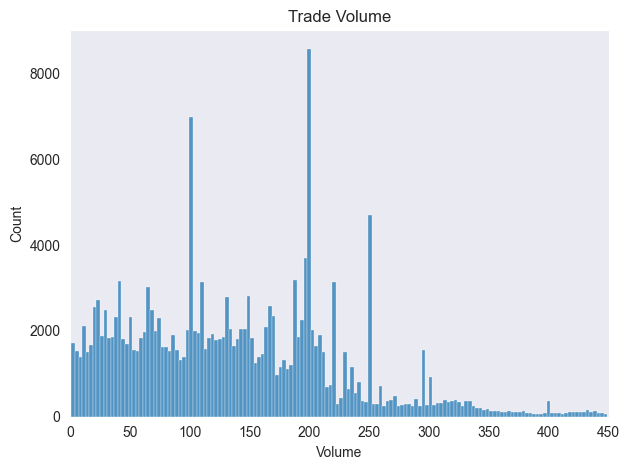

In [15]:
x_sup = 450

sns.histplot(df_trades.loc[df_trades['eqty'] < x_sup], 
             x='eqty', kde=False, bins=150)
plt.xlim(0, x_sup)
plt.title('Trade Volume')
plt.xlabel('Volume')
plt.ylabel('Count')
plt.tight_layout()
plt.grid()
plt.show()

We can appreciate from the previous graph, that some trade volumes are very high, specially for the amount of 100, 200, 250 and 300; compared to their neighbor values.

Calculating best minimal value for power law fit


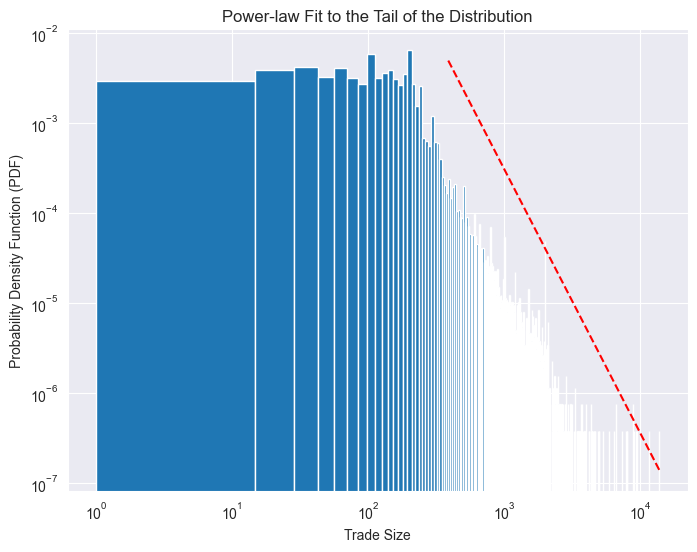

Power-law alpha: 2.9338984978017417
Power-law xmin: 389.0


In [16]:
# Use the powerlaw package to fit the data
fit = powerlaw.Fit(df_trades["eqty"])

plt.figure(figsize=(8, 6))

alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
plt.hist(df_trades["eqty"], bins=1000, density=True)
fit.power_law.plot_pdf(color='r', linestyle='--')

plt.xlabel('Trade Size')
plt.ylabel('Probability Density Function (PDF)')
plt.title('Power-law Fit to the Tail of the Distribution')
plt.show()

# Print the estimated parameters
print(f"Power-law alpha: {alpha}")
print(f"Power-law xmin: {xmin}")

## Part II

### 4. Spread. Are you dealing with large-tick stocks or small-tick stocks ? Compute the empirical distribution of the spread in event time (each observed value counts for one observation) and in calendar time (each observed value is weighted by the length of the time interval on which it is observed). What do you observe ?

In [48]:
df_trades['spread'] = df_trades['ap0'] - df_trades['bp0']

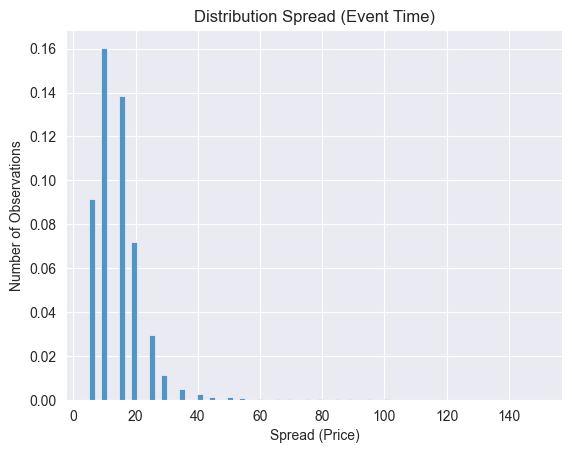

In [74]:
plt.figure()
sns.histplot(df_trades, x='spread', 
             bins=75, kde=False,
             stat='density')

plt.title("Distribution Spread (Event Time)")
plt.xlabel("Spread (Price)")
plt.ylabel("Number of Observations")
plt.show()

We can see from the data, that this is a small tick stock, meaning there is a large span of values for the spread. This is surprising, knowing that SG stock is one of the most liquid stock on the france stock exchange.

In [56]:
spread_counts = df['spread'].value_counts().sort_index()
spread_freq = spread_counts / spread_counts.sum()
print(spread_freq.head(10))

spread
5     0.098209
10    0.277866
15    0.326967
20    0.208640
25    0.056001
30    0.014806
35    0.006240
40    0.003323
45    0.001875
50    0.001418
Name: count, dtype: float64


In [60]:
df_trades = df[df['etype'] == 'T'].copy()
df_trades['ets'] = pd.to_datetime(df_trades['ets'])
df_trades = df_trades.set_index('ets').sort_index()

# Restrict to trading hours (09:00:00–17:30:00)
df_trades = df_trades.between_time('09:00:00', '17:30:00')

# Compute durations within each day and 
# group by date so that .diff() doesn't span overnight
def add_daily_durations(group):
    group = group.sort_index()
    group['trade_duration'] = group.index.to_series().diff().dt.total_seconds()
    return group

# Group by each calendar day
df_trades = df_trades.groupby(df_trades.index.date, group_keys=False
                              ).apply(add_daily_durations)


df_trades = df_trades.dropna(subset=['trade_duration']) # first trade of each day

In [63]:
# Group by the spread and sum up the seconds
spread_time_sums = df_trades.groupby('spread')['trade_duration'].sum()

# Total time across all spreads
total_time = spread_time_sums.sum()

# Fraction of total clock time that each spread was active
spread_freq_calendar = spread_time_sums / total_time

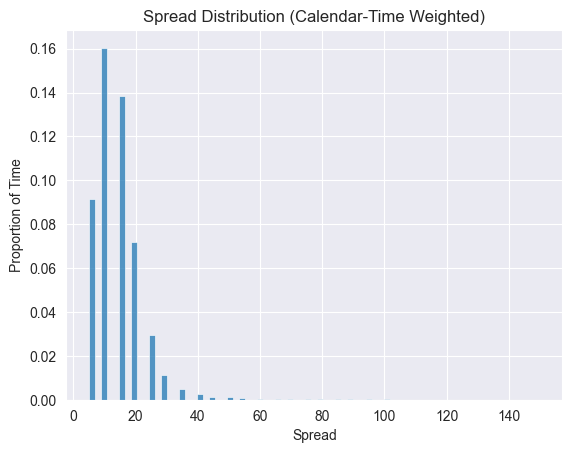

In [79]:
plt.figure()
sns.histplot(df_trades, x='spread', bins=75, kde=False,
                stat='density')
plt.title("Spread Distribution (Calendar-Time Weighted)")
plt.xlabel("Spread")
plt.ylabel("Proportion of Time")
plt.show()

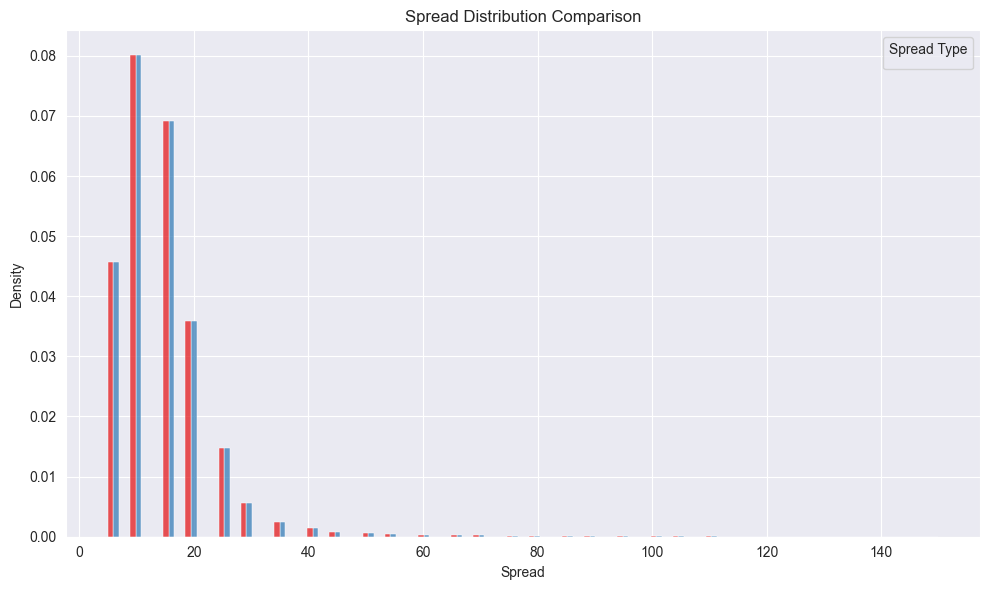

In [92]:
df_event = df_trades.copy()
df_event["SpreadType"] = "Event Time"

df_calendar = df_trades.copy()
df_calendar["SpreadType"] = "Calendar-Time Weighted"

df_long = pd.concat([df_event, df_calendar])

plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_long, x='spread', hue='SpreadType', bins=75, 
                  kde=False, stat='density', multiple='dodge', palette="Set1", legend=True)

plt.title("Spread Distribution Comparison")
plt.xlabel("Spread")
plt.ylabel("Density")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Spread Type")

plt.tight_layout()
plt.show()



### 5. High-frequency log-returns Analyze the log-returns in your dataset for various sampling frequencies in calendar time. Is the Gaussian assumption satisfied ? Is it better in event time ?

In [23]:
df_trades_min = df.copy()
df_trades_min['ets'] = pd.to_datetime(df_trades_min['ets'])
df_trades_min.set_index('ets', inplace=True)
df_trades_min_resampled = df_trades_min.copy()
df_trades_min_resampled = df_trades_min['eprice'].resample('min').last()
df_trades_min_resampled

ets
2017-01-17 09:01:00    46175.0
2017-01-17 09:02:00    46175.0
2017-01-17 09:03:00    46000.0
2017-01-17 09:04:00    45995.0
2017-01-17 09:05:00    45890.0
                        ...   
2017-02-01 17:25:00    46090.0
2017-02-01 17:26:00    45755.0
2017-02-01 17:27:00    46050.0
2017-02-01 17:28:00    46065.0
2017-02-01 17:29:00    45085.0
Freq: min, Name: eprice, Length: 22109, dtype: float64

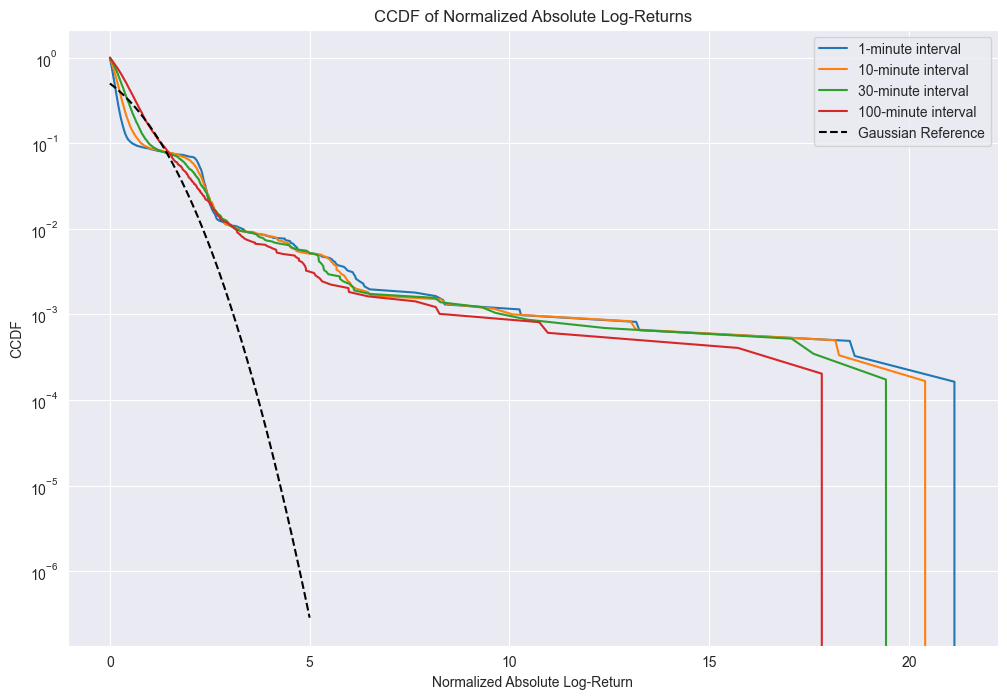

In [24]:
plt.figure(figsize=(12, 8))

frequencies = [1, 10, 30, 100]

for freq in frequencies:
    log_ret = np.log(df_trades_min_resampled / df_trades_min_resampled.shift(freq)).dropna()

    normalized_abs_log_ret = np.abs((log_ret - np.mean(log_ret)) / np.std(log_ret))
    
    sorted_data = np.sort(normalized_abs_log_ret)
    ccdf = 1. - np.arange(1, len(sorted_data)+1) / len(sorted_data)
    
    plt.semilogy(sorted_data, ccdf, label=f'{freq}-minute interval')

gaussian_x = np.linspace(0, 5, 1000)
gaussian_ccdf = 1. - stats.norm.cdf(gaussian_x)
plt.semilogy(gaussian_x, gaussian_ccdf, 'k--', label='Gaussian Reference')

plt.title('CCDF of Normalized Absolute Log-Returns')
plt.xlabel('Normalized Absolute Log-Return')
plt.ylabel('CCDF')
plt.legend()
plt.grid(True)
plt.show()

We see that we are totally out of the gaussian scope and more interestingly : the frequency at which we look at the log-returns matter, the faster the frequency the less gaussian in principle. Ranked from time range log returns -> makes sense

In [25]:
df_trades = df[df['etype'] == 'T'].copy()
df_trades = df_trades.sort_values('ets')
df_trades = df_trades.reset_index(drop=True)

df_trades['log_return'] = np.log(df_trades['eprice'] / df_trades['eprice'].shift(1))
df_trades['variance_log_returns'] = df_trades['log_return'].expanding().var(ddof=1) # cumulative variance -> follows a simily-gaussian after quite some time !
df_trades = df_trades.dropna()
df_trades.head(1)

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,mid_price,weighted_mid_price,tick_size_bid,tick_size_ask,spread,ts_next,delta,log_return,variance_log_returns
2,2017-01-17 09:01:08.444495,T,46085,484,S,46010,855,46085,731,46047.5,46050.431904,0.0,0.0,75,1970-01-01 00:00:00.000000053,1.000000e-09,0.000109,5.886240e-09


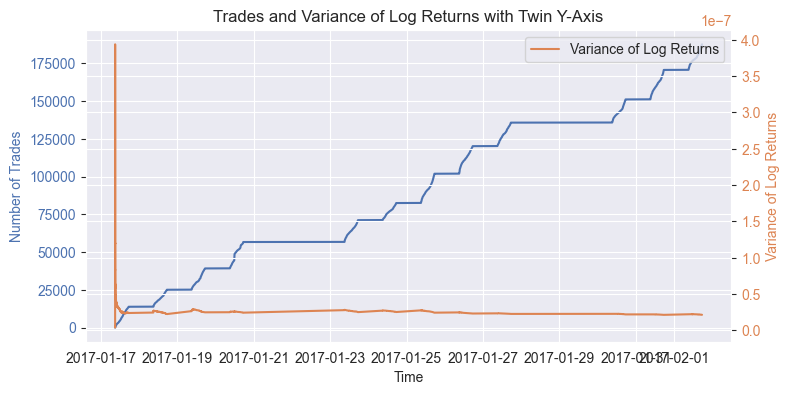

In [26]:
fig, ax1 = plt.subplots(figsize=(8, 4))
colors = sns.color_palette("deep")

ax1.plot(df_trades['ets'], np.arange(1, len(df_trades) + 1), 
         label='Number of Trades', color=colors[0])
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Trades', color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

ax2 = ax1.twinx()
sns.lineplot(data=df_trades, x='ets', y='variance_log_returns', 
             label='Variance of Log Returns', ax=ax2, color=colors[1])
ax2.set_ylabel('Variance of Log Returns', color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

fig.tight_layout()
plt.title('Trades and Variance of Log Returns with Twin Y-Axis')
plt.grid(True)
plt.show()

### 6. Imbalance Is the imbalance a good predictor of mid-price moves or trade signs ?

### 7. Autocorrelations. Sign the trades and analyze the autocorrelation function of this timeseries. Sign the LOB events depending the sign of their price pressure and analyze the autocorrelation function of this timeseries. Sign the LOB events depending the impacted side of the limit order book and analyze the autocorrelation function of this timeseries.